In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from sklearn.metrics import confusion_matrix
import time
from datetime import timedelta
import math

In [2]:
tf.__version__

'0.12.0-rc0'

In [6]:
filter_size1 = 5
num_filters1 = 16

filter_size2 = 5
num_filters2 = 36

fc_size = 128

from tensorflow.examples.tutorials.mnist import input_data
# This is how tensorflow reads data from a source.
data = input_data.read_data_sets('data/MNIST/', one_hot=True)

Extracting data/MNIST/train-images-idx3-ubyte.gz
Extracting data/MNIST/train-labels-idx1-ubyte.gz
Extracting data/MNIST/t10k-images-idx3-ubyte.gz
Extracting data/MNIST/t10k-labels-idx1-ubyte.gz


In [32]:
# One-Hot labels so we can show numbers as integers for test-set.
# The data class consists of everything associated with the data(training data, testing data, validation data)
print type(data)
print("Size of:")
# We can determine the size of the data of each type(training, testing and validation)
print("- Training-set:\t\t{}".format(len(data.train.labels)))
# Each data label is an array that is one-hot encoded and it points to the classified number
print type(data.train.labels)
# The first element of the training label array points to the number 7
print data.train.labels[0]
# Similar idea applies to the test labels
print("- Test-set:\t\t{}".format(len(data.test.labels)))
print type(data.test.labels)
# The first element of the test label array points to the number 7 also
print data.test.labels[0]
# Similar idea applies to the validation labels
print("- Validation-set:\t{}".format(len(data.validation.labels)))
print type(data.validation.labels)
# The first element of the test label array points to the number 5
print data.validation.labels[0]

<class 'tensorflow.contrib.learn.python.learn.datasets.base.Datasets'>
Size of:
- Training-set:		55000
<type 'numpy.ndarray'>
[ 0.  0.  0.  0.  0.  0.  0.  1.  0.  0.]
- Test-set:		10000
<type 'numpy.ndarray'>
[ 0.  0.  0.  0.  0.  0.  0.  1.  0.  0.]
- Validation-set:	5000
<type 'numpy.ndarray'>
[ 0.  0.  0.  0.  0.  1.  0.  0.  0.  0.]


In [60]:
# Argmax retrieves the largest index value in the data.test.labels array
data.test.cls = np.argmax(data.test.labels, axis=1)
data.train.cls = np.argmax(data.train.labels, axis=1)
# print data.test.cls

In [61]:
# The dimension of the image that is fed into the conv net is 28px by 28px
img_size = 28
img_size_flat = img_size * img_size
img_shape = (img_size, img_size)
# Since the image is gray-scale, it only consists of 1 color channel
num_channels = 1
# The total number of classes are 10 (numbers 0-9)
num_classes = 10

In [62]:
# This function is a helper function to aid in plotting the images from the dataset.
def plot_images(images, cls_true, cls_pred=None):
    
    # Create figure with 3x3 sub-plots.
    fig, axes = plt.subplots(4, 4)
#     print "FIG", type(fig)
#     print fig[0]
#     print "AXES", type(axes)
    fig.subplots_adjust(hspace=0.5, wspace=0.5)
    
    for i, ax in enumerate(axes.flat):
        # Plot image.
        ax.imshow(images[i].reshape(img_shape), cmap='binary')

        # Show true and predicted classes.
        # If the class pred is set to none, only the true class is revealed else both the predicted and true class are revealed.
        if cls_pred is None:
            xlabel = "True: {0}".format(cls_true[i])
        else:
            xlabel = "True: {0}, Pred: {1}".format(cls_true[i], cls_pred[i])

        # Show the classes as the label on the x-axis.
        ax.set_xlabel(xlabel)
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

First 16 Test Data


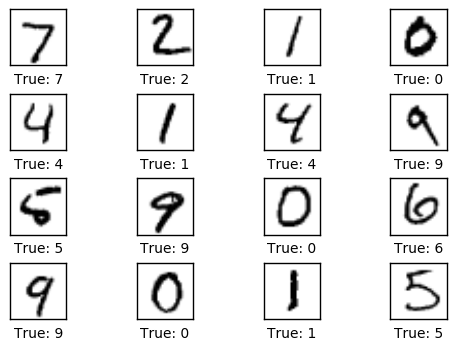

###########################################################
First 16 Train Data


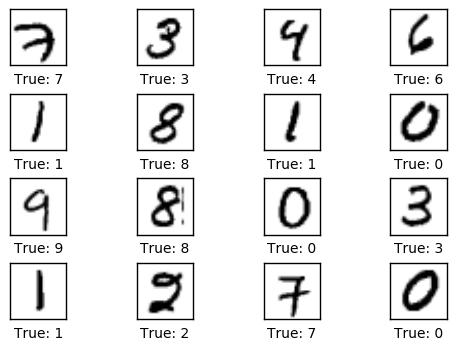

In [68]:
# Get the first 16 images from the test-set.
images = data.test.images[0:16]

# Get the true classes for those images.
cls_true = data.test.cls[0:16]

# Plot the images and labels using our helper-function above.
print "First 16 Test Data"
plot_images(images=images, cls_true=cls_true)

print "###########################################################"

imagesdos = data.train.images[0:16]
cls_truedos = data.train.cls[0:16]
print "First 16 Train Data"
plot_images(images=imagesdos, cls_true=cls_truedos)

In [74]:
# Declaring a function that determines the weights of a layer(random)
def new_weights(shape):
    return tf.Variable(tf.truncated_normal(shape, stddev=0.05))

# Declaring a function that determines the biases of a layer(random).
def new_biases(length):
    return tf.Variable(tf.constant(0.05, shape=[length]))

In [98]:
# A convolutional layer constructing function.
def new_conv_layer(input, num_input_channels, filter_size, num_filters, use_pooling=True):  
    
#     print type(input)
    
    # Shape of the filter-weights for the convolution.
    shape = [filter_size, filter_size, num_input_channels, num_filters]
#     print "SHAPE",shape

    # Creating new filters with the given shape.
    weights = new_weights(shape=shape)
#     print "new_weights",type(weights)
    # Create new biases, one for each filter.
    biases = new_biases(length=num_filters)
#     print "new_biases",type(biases)
    
    # A conv layer is created with params input, filter(which were quantified by weights), stides (which are values that dictate movement of the filter on top of the image)
    # Padding is "Same" and that means outpit size is the same as the input.
    # docs (https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#conv2d)
    layer = tf.nn.conv2d(input=input, filter=weights, strides=[1, 1, 1, 1], padding='SAME')

    # A bias-value is added to each filter
    layer += biases

    # Use pooling to down-sample the image resolution (to 14 X 14  px)
    if use_pooling:
        # docs (https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#max_pool)
        layer = tf.nn.max_pool(value=layer, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

    # Rectified Linear Unit (ReLU) (NON LINEARITY)
    layer = tf.nn.relu(layer)

    # We return both the resulting layer and weights are returned for easy plotting later.
#     print "LAYER", layer
#     print "WEIGHTS", weights
    return layer, weights

In [115]:
# Accepts a 4d tensor from the last layer
def flatten_layer(layer):
    layer_shape = layer.get_shape()
    print "Input Layer shape:",layer_shape
    # layer_shape = [num_images, img_height, img_width, num_channels]
    
    #The number of features is img_height * img_width * num_channels.
    num_features = layer_shape[1:4].num_elements()
    print "Num features", num_features
    
    # The layer is reshaped. -1 means that the reshape does not affect that dimension, only the num_features dimension.
    # In short, -1 flattens the tensor.
    layer_flat = tf.reshape(layer, [-1, num_features])
    print "Output layer shape", layer_flat
    # layer_flat shape is now [num_images, num_features(img_height * img_width * num_channels)]
    
    return layer_flat, num_features

In [116]:
# Input here is a 2 dimensional tensor that was previously flatenned.
def new_fc_layer(input, num_inputs, num_outputs, use_relu=True):
    # Using earlier created helper functions
    weights = new_weights(shape=[num_inputs, num_outputs])
    biases = new_biases(length=num_outputs)
    
    # Here the layer is actually calculated and the weights and biases do play a role.
    layer = tf.matmul(input, weights) + biases
    
    if use_relu:
        layer = tf.nn.relu(layer)
    
    return layer

In [117]:
# Means each input will be an input vector of [?, img_size_flat]
x = tf.placeholder(tf.float32, shape = [None, img_size_flat], name='x')

In [118]:
x_image = tf.reshape(x, [-1, img_size, img_size, num_channels])

y_true = tf.placeholder(tf.float32, shape=[None, 10], name = 'y_true')

y_true_cls = tf.argmax(y_true, dimension=1)

In [119]:
# layer & weights are the return products of the new_conv_layer() function and we see that they are both tensors of varying shapes.
layer_conv1, weights_conv1 = new_conv_layer(input=x_image, num_input_channels=num_channels, filter_size=filter_size1, num_filters=num_filters1, use_pooling=True)

In [120]:
print x_image
print layer_conv1
print weights_conv1

Tensor("Reshape_5:0", shape=(?, 28, 28, 1), dtype=float32)
Tensor("Relu_7:0", shape=(?, 14, 14, 16), dtype=float32)
Tensor("Variable_14/read:0", shape=(5, 5, 1, 16), dtype=float32)


In [121]:
layer_conv2, weights_conv2 = new_conv_layer(input=layer_conv1, num_input_channels=num_filters1, filter_size = filter_size2, num_filters = num_filters2, use_pooling=True)

In [122]:
print "Input Image",x_image
# Output of layer_conv2 & weigths after maxpooling
print "Conv Layer 1 output tensor",layer_conv1
print "Conv Layer 2 weights",weights_conv1
# The output of layer 2 is maxpooled and is now half the dimension of the input which was 14 * 14
print "Conv Layer 2 output tensor",layer_conv2
print "Conv Layer 2 weights",weights_conv2

Input Image Tensor("Reshape_5:0", shape=(?, 28, 28, 1), dtype=float32)
Conv Layer 1 output tensor Tensor("Relu_7:0", shape=(?, 14, 14, 16), dtype=float32)
Conv Layer 2 weights Tensor("Variable_14/read:0", shape=(5, 5, 1, 16), dtype=float32)
Conv Layer 2 output tensor Tensor("Relu_8:0", shape=(?, 7, 7, 36), dtype=float32)
Conv Layer 2 weights Tensor("Variable_16/read:0", shape=(5, 5, 16, 36), dtype=float32)


In [125]:
# layer_flat & num_features are outputs of the flatten layer which has an input of layer_conv2 as seen in the above cell.
layer_flat, num_features = flatten_layer(layer_conv2)

Input Layer shape: (?, 7, 7, 36)
Num features 1764
Output layer shape Tensor("Reshape_7:0", shape=(?, 1764), dtype=float32)


In [126]:
layer_flat

<tf.Tensor 'Reshape_7:0' shape=(?, 1764) dtype=float32>

In [127]:
num_features 

1764

In [128]:
# Creating the fully connecting layer by accepting input from the last layer_flat
layer_fc1 = new_fc_layer(input=layer_flat, num_inputs=num_features, num_outputs=fc_size, use_relu = True)   

In [129]:
layer_fc1

<tf.Tensor 'Relu_9:0' shape=(?, 128) dtype=float32>

In [130]:
layer_fc2 = new_fc_layer(input=layer_fc1, num_inputs = fc_size, num_outputs=num_classes, use_relu=False)
layer_fc2

<tf.Tensor 'add_10:0' shape=(?, 10) dtype=float32>

In [132]:
# We make the prediction and retrieve the resulting vector.
y_pred = tf.nn.softmax(layer_fc2)
print y_pred
# Get the class number for the largest element in the above vector.
y_pred_cls = tf.argmax(y_pred, dimension=1)
print y_pred_cls

Tensor("Softmax_1:0", shape=(?, 10), dtype=float32)
Tensor("ArgMax_6:0", shape=(?,), dtype=int64)


In [138]:
# Optimizing cost function to enable better performance of the output.
# We use cross entropy as this is a classification problem.
# The closer y_pred(softmax applied) or layer_fc2 is to y_true, the better the model becomes.
# Therefore, this now becomes an optimization problem(minimization)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=layer_fc2, labels=y_true)
print layer_fc2
print y_true
# print cross_entropy

Tensor("add_10:0", shape=(?, 10), dtype=float32)
Tensor("y_true_4:0", shape=(?, 10), dtype=float32)


In [139]:
cost = tf.reduce_mean(cross_entropy)

In [140]:
optimizer = tf.train.AdamOptimizer(learning_rate=1e-4).minimize(cost)

In [141]:
# Further performance measures to display model progress to user.
correct_prediction = tf.equal(y_pred_cls, y_true_cls)
# tf.cast converts T/F bools to floats(0 for false, 1 for true) and then calculates the mean.
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [142]:
# A tensorflow session is the only way a TF graph can be executed.
session = tf.Session()
# Weights & Biases are initialized before they can be optimized.
session.run(tf.global_variables_initializer())

In [31]:
# Use batches to carry out computations as there are 55,000 training images.
train_batch_size = 64

total_iters = 0

def optimize(num_iters):
    # We update the global iterator
    global total_iters
    
    start_time=time.time()
    for i in range (total_iters, total_iters + num_iters):
        x_batch, y_true_batch = data.train.next_batch(train_batch_size)
        feed_dict_train = {x: x_batch, y_true: y_true_batch}
        
        session.run(optimizer, feed_dict=feed_dict_train)
        
        if i % 100 == 0:
            acc = session.run(accuracy, feed_dict=feed_dict_train)
            msg = "Optimization Iteration: {0:>6}, Training Accuracy: {1:>6.1%}"
            
            print(msg.format(i+1, acc))
    
    total_iters += num_iters
    
    end_time = time.time()
    
    time_diff = end_time - start_time
    
    print("Time usage: " + str(timedelta(seconds=int(round(time_diff)))))

In [32]:
# Plotting images that are mis-classified.
def plot_example_errors(cls_pred, correct):
    incorrect = (correct==False)
    images = data.test.images[incorrect]
    
    images = data.test.images[incorrect]
    
    cls_pred = cls_pred[incorrect]
    
    cls_true = data.test.cls[incorrect]
    
    # Plot the first 9 images.
    plot_images(images=images[0:9],
                cls_true=cls_true[0:9],
                cls_pred=cls_pred[0:9])

In [33]:
def plot_confusion_matrix(cls_pred):
    cls_true = data.test.cls
    cm = confusion_matrix(y_true = cls_true, y_pred = cls_pred)
    print(cm)
    plt.matshow(cm)
    
    plt.colorbar()
    tick_marks = np.arange(num_classes)
    plt.xticks(tick_marks, range(num_classes))
    plt.yticks(tick_marks, range(num_classes))
    plt.xlabel('Predicted')
    plt.ylabel('True')

    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

In [34]:
# Split the test-set into smaller batches of this size.
test_batch_size = 256

def print_test_accuracy(show_example_errors=False,
                        show_confusion_matrix=False):

    # Number of images in the test-set.
    num_test = len(data.test.images)

    # Allocate an array for the predicted classes which
    # will be calculated in batches and filled into this array.
    cls_pred = np.zeros(shape=num_test, dtype=np.int)

    # Now calculate the predicted classes for the batches.
    # We will just iterate through all the batches.
    # There might be a more clever and Pythonic way of doing this.

    # The starting index for the next batch is denoted i.
    i = 0

    while i < num_test:
        # The ending index for the next batch is denoted j.
        j = min(i + test_batch_size, num_test)

        # Get the images from the test-set between index i and j.
        images = data.test.images[i:j, :]

        # Get the associated labels.
        labels = data.test.labels[i:j, :]

        # Create a feed-dict with these images and labels.
        feed_dict = {x: images,
                     y_true: labels}

        # Calculate the predicted class using TensorFlow.
        cls_pred[i:j] = session.run(y_pred_cls, feed_dict=feed_dict)

        # Set the start-index for the next batch to the
        # end-index of the current batch.
        i = j

    # Convenience variable for the true class-numbers of the test-set.
    cls_true = data.test.cls

    # Create a boolean array whether each image is correctly classified.
    correct = (cls_true == cls_pred)

    # Calculate the number of correctly classified images.
    # When summing a boolean array, False means 0 and True means 1.
    correct_sum = correct.sum()

    # Classification accuracy is the number of correctly classified
    # images divided by the total number of images in the test-set.
    acc = float(correct_sum) / num_test

    # Print the accuracy.
    msg = "Accuracy on Test-Set: {0:.1%} ({1} / {2})"
    print(msg.format(acc, correct_sum, num_test))

    # Plot some examples of mis-classifications, if desired.
    if show_example_errors:
        print("Example errors:")
        plot_example_errors(cls_pred=cls_pred, correct=correct)

    # Plot the confusion matrix, if desired.
    if show_confusion_matrix:
        print("Confusion Matrix:")
        plot_confusion_matrix(cls_pred=cls_pred)

In [35]:
print_test_accuracy()

Accuracy on Test-Set: 9.5% (947 / 10000)


In [105]:
optimize(num_iters=1)

Optimization Iteration:      1, Training Accuracy:  17.2%
Time usage: 0:00:00


In [106]:
print_test_accuracy()

Accuracy on Test-Set: 14.4% (1436 / 10000)


In [108]:
optimize(num_iters=99)

Time usage: 0:00:13


Accuracy on Test-Set: 69.4% (6943 / 10000)
Example errors:


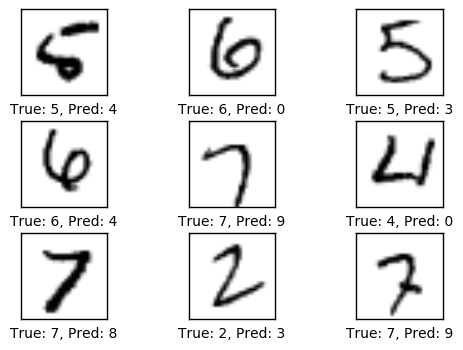

In [109]:
print_test_accuracy(show_example_errors=True)

In [111]:
optimize(num_iters=900)

Optimization Iteration:    101, Training Accuracy:  62.5%
Optimization Iteration:    201, Training Accuracy:  75.0%
Optimization Iteration:    301, Training Accuracy:  81.2%
Optimization Iteration:    401, Training Accuracy:  89.1%
Optimization Iteration:    501, Training Accuracy:  93.8%
Optimization Iteration:    601, Training Accuracy:  89.1%
Optimization Iteration:    701, Training Accuracy:  84.4%
Optimization Iteration:    801, Training Accuracy:  92.2%
Optimization Iteration:    901, Training Accuracy:  93.8%
Time usage: 0:01:51


Accuracy on Test-Set: 93.3% (9335 / 10000)
Example errors:


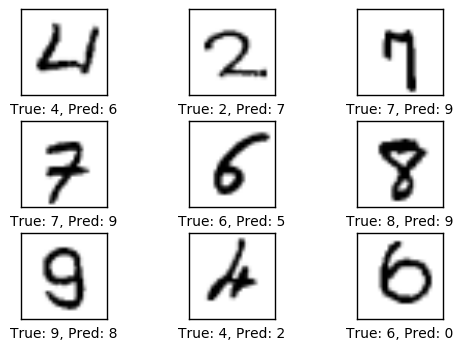

In [112]:
print_test_accuracy(show_example_errors=True)

In [114]:
optimize(num_iters=9000)

Optimization Iteration:   1001, Training Accuracy:  92.2%
Optimization Iteration:   1101, Training Accuracy:  92.2%
Optimization Iteration:   1201, Training Accuracy:  92.2%
Optimization Iteration:   1301, Training Accuracy:  92.2%
Optimization Iteration:   1401, Training Accuracy:  93.8%
Optimization Iteration:   1501, Training Accuracy:  92.2%
Optimization Iteration:   1601, Training Accuracy:  95.3%
Optimization Iteration:   1701, Training Accuracy:  92.2%
Optimization Iteration:   1801, Training Accuracy:  98.4%
Optimization Iteration:   1901, Training Accuracy: 100.0%
Optimization Iteration:   2001, Training Accuracy: 100.0%
Optimization Iteration:   2101, Training Accuracy:  96.9%
Optimization Iteration:   2201, Training Accuracy:  96.9%
Optimization Iteration:   2301, Training Accuracy:  98.4%
Optimization Iteration:   2401, Training Accuracy:  93.8%
Optimization Iteration:   2501, Training Accuracy:  96.9%
Optimization Iteration:   2601, Training Accuracy:  96.9%
Optimization I

Accuracy on Test-Set: 98.9% (9888 / 10000)
Example errors:


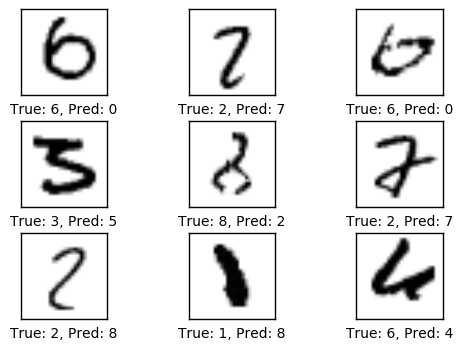

Confusion Matrix:
[[ 976    0    0    0    0    0    1    1    2    0]
 [   0 1130    1    0    1    0    0    2    1    0]
 [   3    2 1018    0    1    0    0    4    4    0]
 [   1    0    1 1001    0    4    0    1    1    1]
 [   0    0    0    0  981    0    0    0    0    1]
 [   2    0    0    4    0  883    1    0    0    2]
 [   6    3    0    0    7    1  941    0    0    0]
 [   0    1    5    2    0    0    0 1019    1    0]
 [   6    1    3    1    2    0    1    2  953    5]
 [   3    4    0    1   10    1    0    3    1  986]]


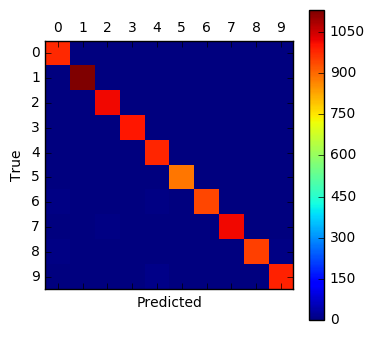

In [116]:
print_test_accuracy(show_example_errors=True, show_confusion_matrix=True)

In [117]:
# Visualizing the weights and layers

def plot_conv_weights(weights, input_channel=0):
    w = session.run(weights)
    
    w_min = np.min(w)
    w_max = np.max(w)
    
    # The number of filters used in a convolutional layer(4th element, 3rd index.)
    num_filters = w.shape[3]
    
    num_grids = math.ceil(math.sqrt(num_filters))
    
    # Create figure with a grid of sub-plots.
    fig, axes = plt.subplots(num_grids, num_grids)

    # Plot all the filter-weights.
    for i, ax in enumerate(axes.flat):
        # Only plot the valid filter-weights.
        if i<num_filters:
            # Get the weights for the i'th filter of the input channel.
            # See new_conv_layer() for details on the format
            # of this 4-dim tensor.
            img = w[:, :, input_channel, i]

            # Plot image.
            ax.imshow(img, vmin=w_min, vmax=w_max,
                      interpolation='nearest', cmap='seismic')
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

In [118]:
def plot_conv_layer(layer, image):
    # Assume layer is a TensorFlow op that outputs a 4-dim tensor
    # which is the output of a convolutional layer,
    # e.g. layer_conv1 or layer_conv2.

    # Create a feed-dict containing just one image.
    # Note that we don't need to feed y_true because it is
    # not used in this calculation.
    feed_dict = {x: [image]}

    # Calculate and retrieve the output values of the layer
    # when inputting that image.
    values = session.run(layer, feed_dict=feed_dict)

    # Number of filters used in the conv. layer.
    num_filters = values.shape[3]

    # Number of grids to plot.
    # Rounded-up, square-root of the number of filters.
    num_grids = math.ceil(math.sqrt(num_filters))
    
    # Create figure with a grid of sub-plots.
    fig, axes = plt.subplots(num_grids, num_grids)

    # Plot the output images of all the filters.
    for i, ax in enumerate(axes.flat):
        # Only plot the images for valid filters.
        if i<num_filters:
            # Get the output image of using the i'th filter.
            # See new_conv_layer() for details on the format
            # of this 4-dim tensor.
            img = values[0, :, :, i]

            # Plot image.
            ax.imshow(img, interpolation='nearest', cmap='binary')
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

In [119]:
def plot_image(image):
    plt.imshow(image.reshape(img_shape),
               interpolation='nearest',
               cmap='binary')

    plt.show()

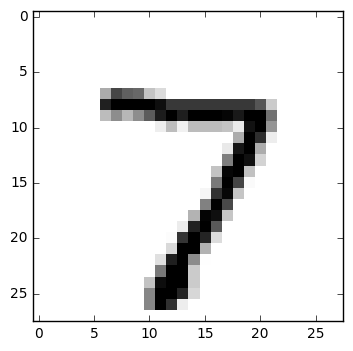

In [120]:
image1 = data.test.images[0]
plot_image(image1)

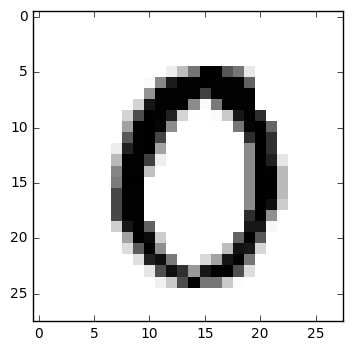

In [121]:
image2 = data.test.images[13]
plot_image(image2)

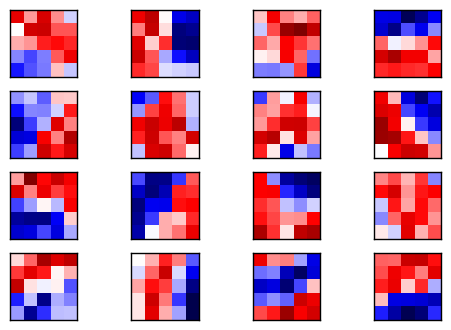

In [122]:
plot_conv_weights(weights=weights_conv1)

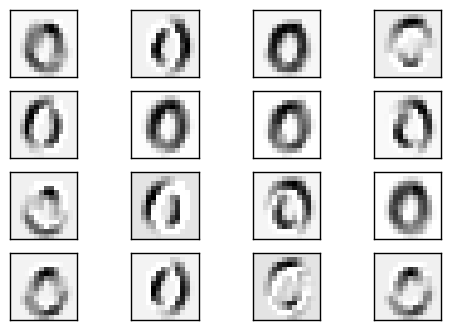

In [123]:
plot_conv_layer(layer=layer_conv1, image=image2)

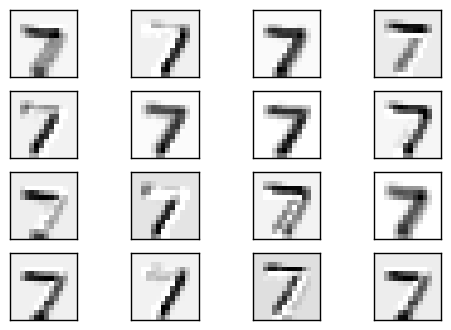

In [124]:
plot_conv_layer(layer=layer_conv1, image=image1)

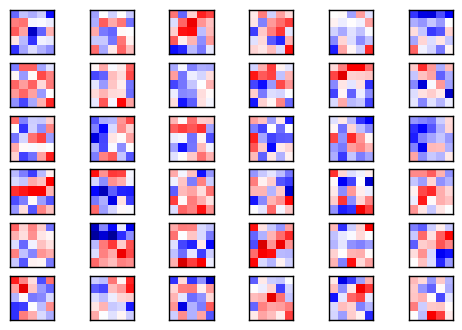

In [125]:
# Plotting Conv2 weights
plot_conv_weights(weights=weights_conv2, input_channel=12)

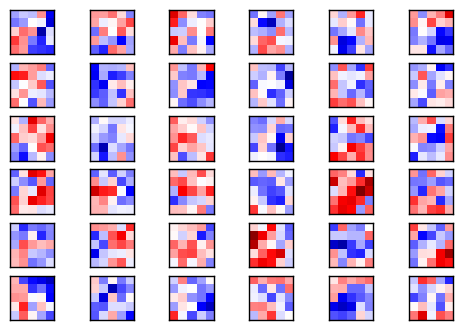

In [126]:
plot_conv_weights(weights=weights_conv2, input_channel=14)

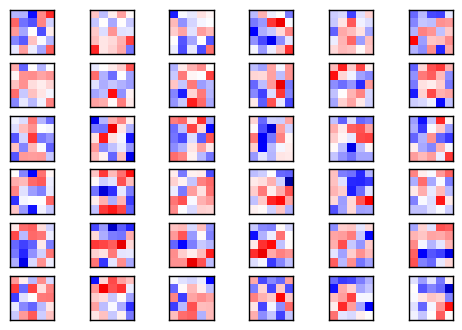

In [127]:
plot_conv_weights(weights=weights_conv2, input_channel=2)

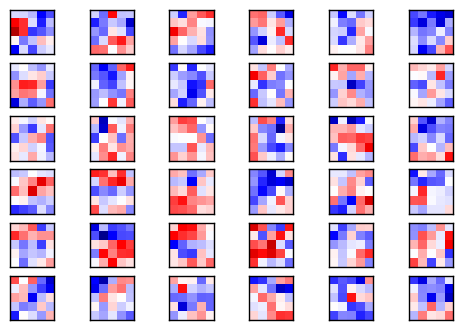

In [129]:
plot_conv_weights(weights=weights_conv2, input_channel=15)

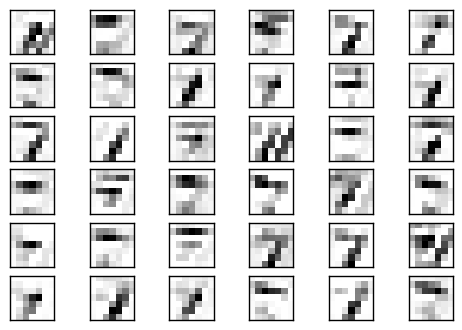

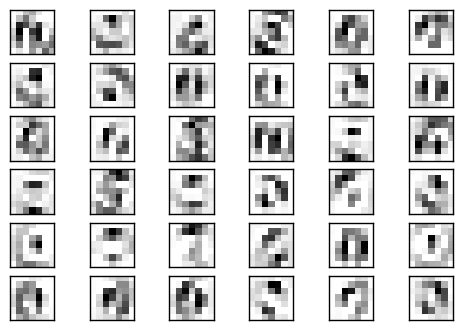

In [130]:
plot_conv_layer(layer=layer_conv2, image=image1)
plot_conv_layer(layer=layer_conv2, image=image2)